In [3]:
# imports 

import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

import seaborn as sns

import datetime
# from datetime import datetime
# import time
# import dateutil.parser
# import random
from random import sample 

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

InteractiveShell.ast_node_interactivity = "all"
# InteractiveShell.ast_node_interactivity = "last"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import dask.dataframe as dd
import functools
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [55]:
# import SA packages
from lifelines import (CoxPHFitter, KaplanMeierFitter, NelsonAalenFitter,
                       WeibullFitter, ExponentialFitter, LogNormalFitter, 
                       LogLogisticFitter, NelsonAalenFitter, 
                       PiecewiseExponentialFitter, GeneralizedGammaFitter, SplineFitter)

from lifelines.plotting import plot_lifetimes


In [4]:
df0 = pd.read_csv('data/ship_df_final.csv', low_memory=False)

In [12]:
df = df0.copy()

In [13]:
df['year'] = [pd.to_datetime(d).year for d in df.order_date]
df = df.query('year >= 2018') # scope

In [15]:
# Event
df.loc[:, 'event'] = df['invoice_payment_status'].apply(lambda x: 1 if x == 'Fully paid' else 0 )

In [16]:
# Time
df['order_date'] = [pd.to_datetime(d) for d in df.order_date]
df['last_date_cycle'] = [pd.to_datetime(d) for d in df.last_date_cycle]

df['t'] = (df.last_date_cycle - df.order_date).dt.days

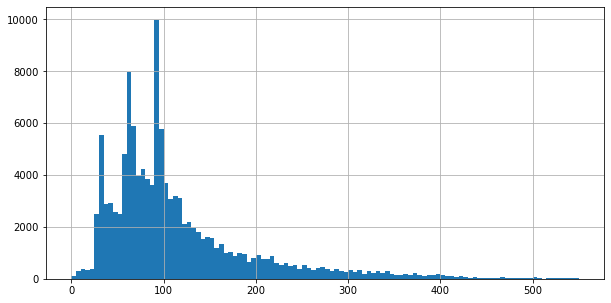

In [19]:
plt.rcParams["figure.figsize"] = [10,5]

df.query('event == 1').t.hist(bins = np.arange(0, 551, 5))
pass;

In [ ]:
df.po_terms.value_counts(dropna = False)

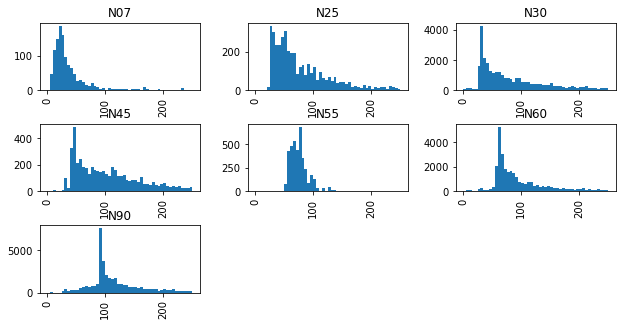

In [21]:
plt.rcParams["figure.figsize"] = [10,5]


df[df.po_terms.isin(['N90', 'N30', 'N60', 'N45', 'N07',
       'N25', 'N55'])].query('event == 1').t.hist(bins = np.arange(0, 251, 5), by = df.po_terms)

pass;

## Top level

### Empiricals: KM and NA

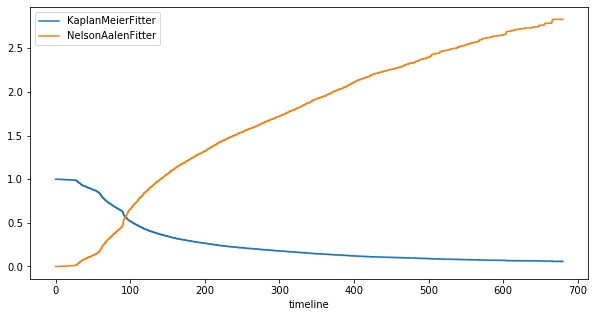

In [50]:
t = df.t
e = df.event

kmf = KaplanMeierFitter().fit(t, e, label='KaplanMeierFitter')
naf = NelsonAalenFitter().fit(t, e, label='NelsonAalenFitter')


kmf.plot_survival_function()
naf.plot_cumulative_hazard()

### Weibull

In [41]:
# Weibull distribution, x, shape, scale
def weib(x, k, l): 
    return (k / l) * (x / l)**(k - 1) * np.exp(-(x / l)**k)

In [ ]:
# df = df.query("po_terms == 'N90' & t != 0")

In [33]:
df.shape
df = df[df.t != 0]
df.shape

(166476, 78)

(166211, 78)

In [35]:
t = df.t
e = df.event

wf = WeibullFitter()
wf.fit(t, e)

wf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 166211 total observations, 44782 right-censored observations>

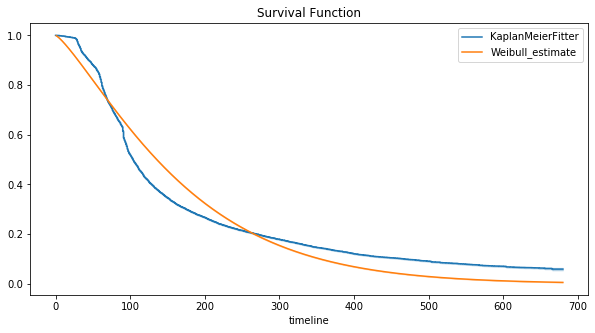

In [57]:
kmf.plot_survival_function()
wf.plot_survival_function()
plt.title('Survival Function')

pass;

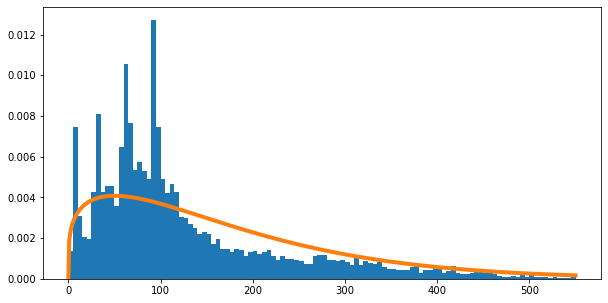

In [54]:
plt.hist(t, bins = np.arange(0, 551, 5), density = True)

x = np.arange(0, 551)
plt.plot(x, weib(x, k = wf.rho_, l = wf.lambda_), linewidth = 4)

pass;

## Regression

In [58]:
df.head(3)

,invoice_id,po_line_unique_id,first,po_number,release,requisition_number,requisition_line,po_type,po_approval_status,order_date,supplier,supplier_site,currency,rate,buyer,po_closure_status,po_cancelled,"po_description,",line_number,line_category,line_description,line_quantity,uom,unit_price,line_amount,line_type,line_cancelled,line_closure_status,shipment_number,shipment_cancelled,shipment_amount,shipment_quantity,quantity_due,quantity_received,quantity_accepted,quantity_rejected,quantity_billed,quantity_cancelled,authorization,need_by_date,promised_date,invoice_match_option,accrue_on_receipt,distribution_number,charge_account,distribution_amount,requestor,preparer,project,project_type,expenditure_type,task,project_asset_name,receipt_number,transaction_receipt_date,item,matching_type,ship_to_location,planner,subinventory,distribution_category,invoice_number,contract_number,thuiskopieerheffing,po_terms,original_promised_date,po_header_id,po_line_id,supplier_id,supplier_number,party_id,vendor_site_id,snapshot_date,invoice_payment_status,last_date_cycle,year,event,t
146825,4890338.0,3263928_1,D,3263928,NaN,7285853.0,1.0,Standard Purchase Order,APPROVED,2018-03-29 14:10:21,Huawei Technologies (Netherlands) B.V.,EUR AMSTERDAM,EUR,NaN,Kanhai,CLOSED,False,NaN,1.0,0145,840086 Hua NE40E-M2 Base SW,90.0,STK,432.0,38880.0,Goods,False,CLOSED,1,NaN,38880.0,90.0,0.0,90.0,0.0,0.0,90.0,0.0,APPROVED,2018-04-03 11:22:32,NaN,PO,Y,1.0,336.13348.0340.XXXX.XXXX.X.XXX.0000.0000,38880.0,Tempel,Tempel,K30325,Doorlopende Invest,Licenties,2.C.140,NaN,842889.0,2018-04-23 14:03:20,NaN,3-Way,AMF 30091 A,NaN,NaN,NaN,"NL1706166,NL1802131,NL1802153",3054163.0,NaN,N90,NaN,4855113.0,4459852.0,4029.0,34335.0,NaN,NaN,2019-04-12 13:25:02,Fully paid,2018-04-06,2018,1,7
146826,4890338.0,3263928_2,D,3263928,NaN,7285853.0,2.0,Standard Purchase Order,APPROVED,2018-03-29 14:10:21,Huawei Technologies (Netherlands) B.V.,EUR AMSTERDAM,EUR,NaN,Kanhai,CLOSED,False,NaN,2.0,0145,840086 Hua NE40E-M2 Base SW,90.0,STK,432.0,38880.0,Goods,False,CLOSED,1,NaN,38880.0,90.0,0.0,90.0,0.0,0.0,90.0,0.0,APPROVED,2018-04-03 11:22:32,NaN,PO,Y,1.0,336.13348.0340.XXXX.XXXX.X.XXX.0000.0000,38880.0,Tempel,Tempel,K30325,Doorlopende Invest,Licenties,2.C.140,NaN,842889.0,2018-04-23 14:03:20,NaN,3-Way,AMF 30091 A,NaN,NaN,NaN,"NL1706166,NL1802131,NL1802153",3054163.0,NaN,N90,NaN,4855113.0,4459853.0,4029.0,34335.0,NaN,NaN,2019-04-12 13:25:02,Fully paid,2018-04-06,2018,1,7
148084,4947367.0,3255314_1,D,3255314,NaN,7270593.0,1.0,Standard Purchase Order,APPROVED,2018-01-03 10:24:44,Cisco Systems Management B.V.,USD AMSTERDAM,USD,0.83382,Douglas Kabel,CLOSED,False,Deal ID 18146432 Web Order ID 82249860,1.0,0152,Dec 2017 McAfee support 4716658122 -,1.0,STK,60060.0,60060.0,Services,False,CLOSED,1,NaN,60060.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,APPROVED,2017-12-15 00:00:00,NaN,PO,N,1.0,250.42041.4200.XXXX.XXXX.X.XXX.0000.0000,60060.0,Capriles,Mahesh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-Way,Eenmalig adres,NaN,NaN,NaN,11655940,3233949.0,NaN,N90,NaN,4316174.0,3890905.0,3212.0,3050.0,NaN,NaN,2019-04-12 13:25:02,Fully paid,2018-01-15,2018,1,11


In [ ]:
# Subset for initial regression experimentation 

In [ ]:
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')

cph.print_summary()  # access the results using cph.summary

## Survival Analysis

In [ ]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons

df.po_terms.unique()#value_counts(dropna=False)

# Appendix

In [ ]:
# parse() dates 
# from datetime import datetime
# from dateutil.parser import parse
# import pandas as pd

# parse(df.order_date[10])

# datetime_str = '09/19/18 13:55:26'
# parse(datetime_str)

# pd.Series([pd.to_datetime(d).year for d in df.order_date]).value_counts()

In [ ]:
# to_datetime() 
# df['year'] = [pd.to_datetime(d).year for d in df.order_date]

# df.groupby('year')['invoice_payment_status'].value_counts(dropna=False)
# df.shape


In [ ]:
# Weibull 
# def weib(x, n, a): 
#     return (a / n) * (x / n)**(a - 1) * np.exp(-(x / n)**a)

# count, bins, ignored = plt.hist(np.random.weibull(5.,1000))
# x = np.arange(1,100.)/50.
# scale = count.max()/weib(x, 1., 5.).max()
# plt.plot(x, weib(x, 1., 5.)*scale)
# plt.show()

In [ ]:
# Column finder 
# df.columns[['status' in c for c in df.columns]]
# df[df.columns[['date' in c for c in df.columns]]].head(2)